In [11]:
# Modules, Configs, Utils
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T

# !pip install SoundFile
import soundfile
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

# 클래스 개수
NUM_CLASSES = 6
AUDIO_STANDARD_LENGTH = 160000
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False

# 음성 데이터 불러오기
def get_speech(file_path):
    waveform, sample_rate = torchaudio.backend.soundfile_backend.load(file_path)

    length = waveform.size(1)
    result = torch.zeros((1, AUDIO_STANDARD_LENGTH))
    idx = (AUDIO_STANDARD_LENGTH - waveform.size(1)) // 2

    result[0, idx:idx+length] = waveform

    return result, sample_rate 

n_fft = 512
win_length = 512
hop_length = 256
n_mels = 128

# Melspectogram 변환
def make_melspectogram(audio_path):
    waveform, sample_rate = get_speech(audio_path)
    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )

    melspec = mel_spectrogram(waveform)             # 결과값

    return True, melspec


In [12]:
class DialectAudioDataset(Dataset):
    def __init__(self, label_file, root_dir, transform=None, target_transform=None):
        with open(label_file, 'r', encoding='UTF-8') as f:
            self.audio_datas = [l.rstrip().split('\t') for l in f.readlines()]
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_datas)
    
    def __getitem__(self, idx):
        audio_path = self.root_dir + self.audio_datas[idx][0]
        # audio melspectogram
        # image = read_image(img_path)
        # audio = get_speech(self.root_dir, self.audio_datas[idx][0])
        
        # print(self.audio_datas[idx])
        
        # 경로상 오류있음, 처리
        audio_path = audio_path.replace('06.경제', '6.경제')

        # 데이터 로드 시 melspec처리까지 진행, 확인했을 때 25정도까지도 줄어들었음
        audio = make_melspectogram(audio_path)[1]
        
        # label은 0부터 시작
        label = torch.tensor([int(self.audio_datas[idx][1]) - 1], dtype=torch.long)

        # zero padding, noise padding 필요
        if self.transform:
            audio = self.transform(audio)
        if self.target_transform:
            label = self.target_transform(label)

        return audio, label

In [13]:
# 서버 경로
ZIP_BASE_DIR = '/data/team2/audio/'
EXTRACT_BASE_DIR = ZIP_BASE_DIR + 'Training/data/remote/PROJECT/AI학습데이터/KoreanSpeech/data'

In [14]:
# 데이터 로드
training_data = DialectAudioDataset('../audio_data_train', EXTRACT_BASE_DIR)
testing_data = DialectAudioDataset('../audio_data_test', EXTRACT_BASE_DIR)

In [15]:
stretch = T.TimeStretch()

In [ ]:
stretch(training_data[0][0], 1.2)

In [28]:
# !pip install librosa
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [23]:
training_data[3][0].size()

torch.Size([1, 128, 626])

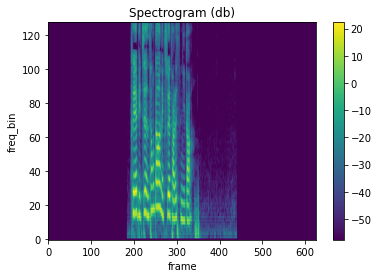

In [30]:
plot_spectrogram(training_data[3][0][0])

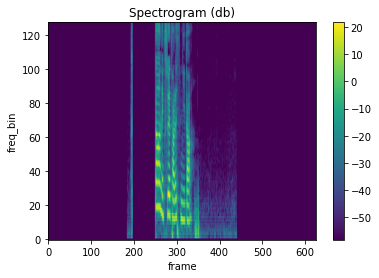

In [36]:

plot_spectrogram(masking(training_data[3][0])[0])

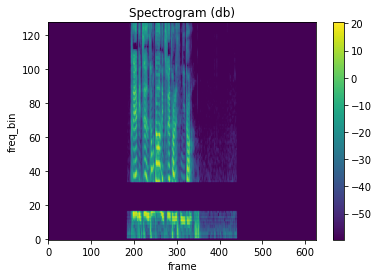

In [48]:

plot_spectrogram(masking(training_data[3][0])[0])

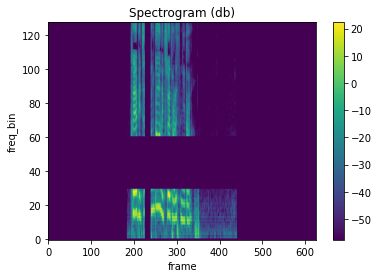

In [83]:
import random
# 인자를 여러개로 바꾸어가면서 처리해봐야 할 듯
time_masking = T.TimeMasking(time_mask_param=80)
# 40 정도로 줄였었음
freq_masking = T.FrequencyMasking(freq_mask_param=80)
# 10, 20, 30, 40, or 아예 augmentation에서 random select

def custom_aug(spec):
    random_value = random.random()
    # time masking
    if random_value > 0.5 :
        spec = time_masking(spec)
    random_value = random.random()

    # freq masking
    if random_value > 0.5:
        spec = freq_masking(spec)

    # print(random_value)

    return spec

plot_spectrogram(custom_aug(training_data[3][0])[0])

In [ ]:
# time stretch augmentation은 좀더 확인이 필요할듯
# torch size를 변경함에 따라 연산이 되지 않는 상황도 발생
